In [1]:
# Math Operations
import numpy as np
from math import pi

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
!pip install soccerplots
import soccerplots
from soccerplots.radar_chart import Radar   # for custom radar visuals

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Progress Bar
from tqdm import tqdm

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Print Statement
print('All necessary libraries imported.')

All necessary libraries imported.


In [2]:
path = 'C:/Users/user/Desktop/xg-data-analysis/datasets/cleanedAdvanced'
extension = 'csv'
os.chdir(path)
result = glob.glob('*merged.{}'.format(extension))

In [3]:
result

['brighton-firstseason-allmerged.csv',
 'huddersfield-firstseason-allmerged.csv',
 'leeds-firstseason-allmerged.csv',
 'newcastle-firstseason-allmerged.csv',
 'sheffutd-firstseason-allmerged.csv',
 'villa-firstseason-allmerged.csv',
 'wolves-firstseason-allmerged.csv']

In [4]:
#bri_all = pd.read_csv(result[0])
hudds_all = pd.read_csv(result[1])
leeds_all = pd.read_csv(result[2])
newcastle_all = pd.read_csv(result[3])
sheffutd_all = pd.read_csv(result[4])
villa_all = pd.read_csv(result[5])
wolves_all = pd.read_csv(result[6])

In [5]:
result = pd.concat([hudds_all, leeds_all, newcastle_all, sheffutd_all, villa_all, wolves_all])

In [6]:
result = result[~result['Player'].isin(["Squad Total", "Opponent Total"])]

In [7]:
result.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,55,40,13,2,19,45,...,0,2,4,0.11,4,0,0,0,0,0
1,Christopher Schindler,de GER,DF,27.0,83,56,27,0,24,41,...,0,2,1,0.03,1,0,0,0,0,0
2,Aaron Mooy,au AUS,MF,26.0,102,39,51,12,23,55,...,0,2,7,0.21,5,2,0,0,0,0
3,Jonathan Hogg,eng ENG,MF,28.0,93,29,59,5,26,89,...,3,1,1,0.04,0,0,0,0,1,0
4,Tom Ince,eng ENG,MFFW,25.0,35,14,16,5,10,29,...,5,1,2,0.07,1,0,0,1,0,0


In [8]:
result.shape

(135, 109)

In [9]:
## first take players who only played approx 25% of available mins
result = result[result['Min'] >= 800]
result.shape

(92, 109)

In [10]:
## check for nulls
features_with_na = [features for features in result.columns if result[features].isnull().sum() > 0]

for feature in features_with_na: 
    print(feature, np.round(result[feature].isnull().mean(), 4), '% missing values')
    print(features_with_na)

Min/Start 0.3696 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
Min/Sub 0.5109 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
TeamSuccessOn-Off 0.0326 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
xG-On-Off 0.0326 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
SoT% 0.0109 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
G/Sh 0.0109 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
G/SoT 0.087 % missing values
['Min/Start', 'Min/Sub', 'TeamSuccessOn-Off', 'xG-On-Off', 'SoT%', 'G/Sh', 'G/SoT', 'Dist', 'npxG/Sh']
Dist 0.0109 % missing values
['Min/Start', 'Min/Su

In [11]:
result.fillna(0, inplace=True)

### Clustering Based on Defenders for First Season
This will allow us to see what similarities/differences there are between the performance levels in the first season at each of the clubs in questions. As already stated the majority of clubs here had far stronger second seasons than first seasons so it will be interesting to see any similarities in performance levels.

In [12]:
result_def = result[result['Pos'].str.contains("DF")]

In [13]:
result_def.shape

(40, 109)

In [14]:
per_90_cols = [col for col in result_def.columns if '90' in col]
print(per_90_cols)

['Goals+/-90', 'xG+/-90', 'Sh/90', 'SoT/90', 'SCA90', 'GCA90']


### Need to Standardise our Columns creating a per 90 value for numeric columns without a per 90 value

In [15]:
keep = ["MediumCmp%", "LongCmp%", "ShortCmp%", "AerialDuelWon%",
       "Player", "Pos", "Age", "Nation"]
cols_change = ['Fls', 'Crs', 'Interceptions', 'TklWon', 'Recov','AerialDuelWon', "ProgressiveDist" "TotDist",
               "Assists","xAG","xA","A-xAG","KeyPasses","CompletedFinalThird",
           "PassesPenaltyArea","CrossesPA","ProgressivePasses",
               "Gls","Sh","SoT","SoT%", "xG","npxG","npxG/Sh","G-xG","np:G-xG", "SCAPassLive","SCAPassDead",
                    "SCADrib", "SCASh", "SCAFld", "SCADef", "GCA","GCAPassLive","GCAPassDead","GCADrib",
                    "GCASh", "GCAFld", "GCADef", 'Tkl', 'TklWon',
       'TacklesDef3rd', 'TacklesMid3rd', 'TacklesAtt3rd', 'VSDribblesTkl',
       'VSDribblesAtt', 'VSDribblesTkl%', 'VSDribblesPast', 'Blocks',
       'ShotBlock', 'PassBlock', 'Interceptions', 'Tkl+Int', 'Clearances',
       'Errors']

In [16]:
for column in result_def:
    if column in cols_change and column not in per_90_cols:
        result_def[column] = (result_def[column] / result_def['Min']) * 90
    else:
        continue

C:\Users\user\AppData\Local\Temp/ipykernel_924/3331863228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_def[column] = (result_def[column] / result_def['Min']) * 90


In [17]:
result_def.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,SCAFld,SCADef,GCA,GCA90,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,1.447368,1.052632,0.342105,0.052632,0.500000,1.184211,...,0.000000,0.052632,0.105263,0.11,0.105263,0.000000,0.0,0.0,0.0,0.0
1,Christopher Schindler,de GER,DF,27.0,2.287902,1.543645,0.744257,0.000000,0.661562,1.130168,...,0.000000,0.055130,0.027565,0.03,0.027565,0.000000,0.0,0.0,0.0,0.0
6,Tommy Smith,eng ENG,DF,25.0,1.796218,0.850840,0.661765,0.283613,1.087185,1.701681,...,0.000000,0.094538,0.094538,0.09,0.094538,0.000000,0.0,0.0,0.0,0.0
8,Florent Hadergjonaj,xk KVX,DFMF,23.0,1.129032,0.376344,0.537634,0.215054,0.645161,1.612903,...,0.053763,0.000000,0.053763,0.05,0.053763,0.000000,0.0,0.0,0.0,0.0
9,Chris LÃ¶we,de GER,DF,28.0,2.437028,1.473552,0.850126,0.113350,1.133501,2.493703,...,0.113350,0.113350,0.113350,0.11,0.056675,0.056675,0.0,0.0,0.0,0.0


In [18]:
all_cols_vals = keep + cols_change

In [19]:
result_def = result_def[result_def.columns[result_def.columns.isin(all_cols_vals)]]

In [21]:
result_def.head()

,Player,Nation,Pos,Age,Tkl,TacklesDef3rd,TacklesMid3rd,TacklesAtt3rd,VSDribblesTkl,VSDribblesAtt,...,SCASh,SCAFld,SCADef,GCA,GCAPassLive,GCAPassDead,GCADrib,GCASh,GCAFld,GCADef
0,Mathias JÃ¸rgensen,dk DEN,DF,27.0,1.447368,1.052632,0.342105,0.052632,0.500000,1.184211,...,0.000000,0.000000,0.052632,0.105263,0.105263,0.000000,0.0,0.0,0.0,0.0
1,Christopher Schindler,de GER,DF,27.0,2.287902,1.543645,0.744257,0.000000,0.661562,1.130168,...,0.027565,0.000000,0.055130,0.027565,0.027565,0.000000,0.0,0.0,0.0,0.0
6,Tommy Smith,eng ENG,DF,25.0,1.796218,0.850840,0.661765,0.283613,1.087185,1.701681,...,0.000000,0.000000,0.094538,0.094538,0.094538,0.000000,0.0,0.0,0.0,0.0
8,Florent Hadergjonaj,xk KVX,DFMF,23.0,1.129032,0.376344,0.537634,0.215054,0.645161,1.612903,...,0.053763,0.053763,0.000000,0.053763,0.053763,0.000000,0.0,0.0,0.0,0.0
9,Chris LÃ¶we,de GER,DF,28.0,2.437028,1.473552,0.850126,0.113350,1.133501,2.493703,...,0.056675,0.113350,0.113350,0.113350,0.056675,0.056675,0.0,0.0,0.0,0.0


### PCA / ML

Here we will take a clustering approach to compare how defenders playing a minimum of 800 minutes compared across the different teams in their respective first seasons in the Premier League. This can allow us to compare different styles of play and see was there any clear differences in style between the teams in how they defended. Teams like Huddersfield Town played a more conservative style of play while Leeds United played an aggressive (and some would say naive) man-to-man defensive system relying on individual duels.

In [37]:
numeric_def_s1 = result_def.iloc[:, 4:]

In [72]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
x = numeric_def_s1.values    # NumPy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [73]:
X_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.351038,0.388698,0.237058,0.179898,0.149637,0.291868,0.043859,0.306240,0.499635,0.320155,...,0.000000,0.000000,0.464327,0.367719,0.489035,0.000000,0.0,0.0,0.0,0.0
1,0.651453,0.656947,0.619821,0.000000,0.275974,0.271673,0.148577,0.194552,0.648559,0.532546,...,0.104441,0.000000,0.486371,0.096294,0.128063,0.000000,0.0,0.0,0.0,0.0
2,0.475720,0.278456,0.541305,0.969407,0.608800,0.485241,0.442255,0.270126,0.312914,0.148693,...,0.000000,0.000000,0.834034,0.330252,0.439207,0.000000,0.0,0.0,0.0,0.0
3,0.237261,0.019230,0.423160,0.735066,0.263149,0.452066,0.260794,0.453115,0.419818,0.328151,...,0.203704,0.305556,0.000000,0.187814,0.249776,0.000000,0.0,0.0,0.0,0.0
4,0.704752,0.618654,0.720585,0.387437,0.645018,0.781213,0.350107,0.656418,0.425340,0.268642,...,0.214736,0.644207,1.000000,0.395970,0.263303,0.644207,0.0,0.0,0.0,0.0


In [74]:
pca = PCA()
pca.fit(X_norm)

PCA()

([<matplotlib.axis.XTick at 0x1bce7701a90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

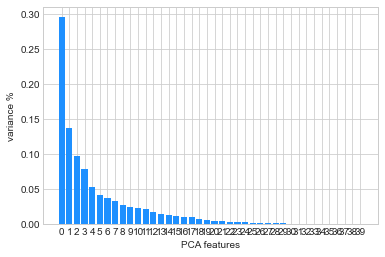

In [75]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'dodgerblue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [79]:
pca_2d = PCA(n_components = 2)

# Save components to a DataFrame
df_reduced = pd.DataFrame(pca_2d.fit_transform(X_norm))

In [87]:
df_reduced.head()

,0,1
0,-0.692480,-0.109900
1,-0.958346,0.255134
2,0.437964,-0.622672
3,0.636381,-1.132626
4,0.554789,0.130715


C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


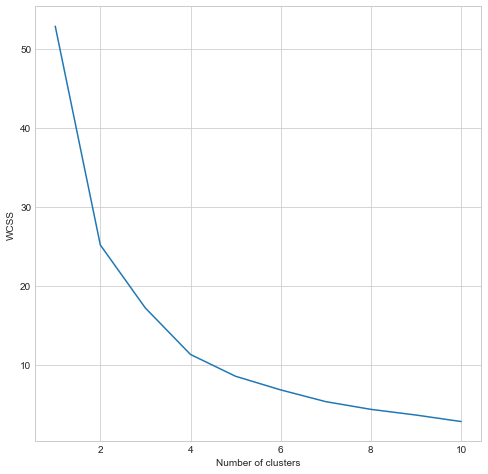

In [81]:
wcss = []

for i in range(1,11):
    model = KMeans(n_clusters = i, init = "k-means++", max_iter = 600, random_state=42)
    model.fit(df_reduced)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [94]:
# K-Means Clustering

## Specify the number of clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=600, random_state=42)

## Fit the input data
kmeans = kmeans.fit(df_reduced)

## Get the cluster labels
labels = kmeans.predict(df_reduced)

## Centroid values
centroid = kmeans.cluster_centers_

## Cluster values
clusters = kmeans.labels_.tolist()

In [95]:
x_coord = df_reduced[0].tolist()
y_coord = df_reduced[1].tolist()
result_def['X'] = x_coord
result_def['Y'] = y_coord
result_def['Cluster'] = clusters

C:\Users\user\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


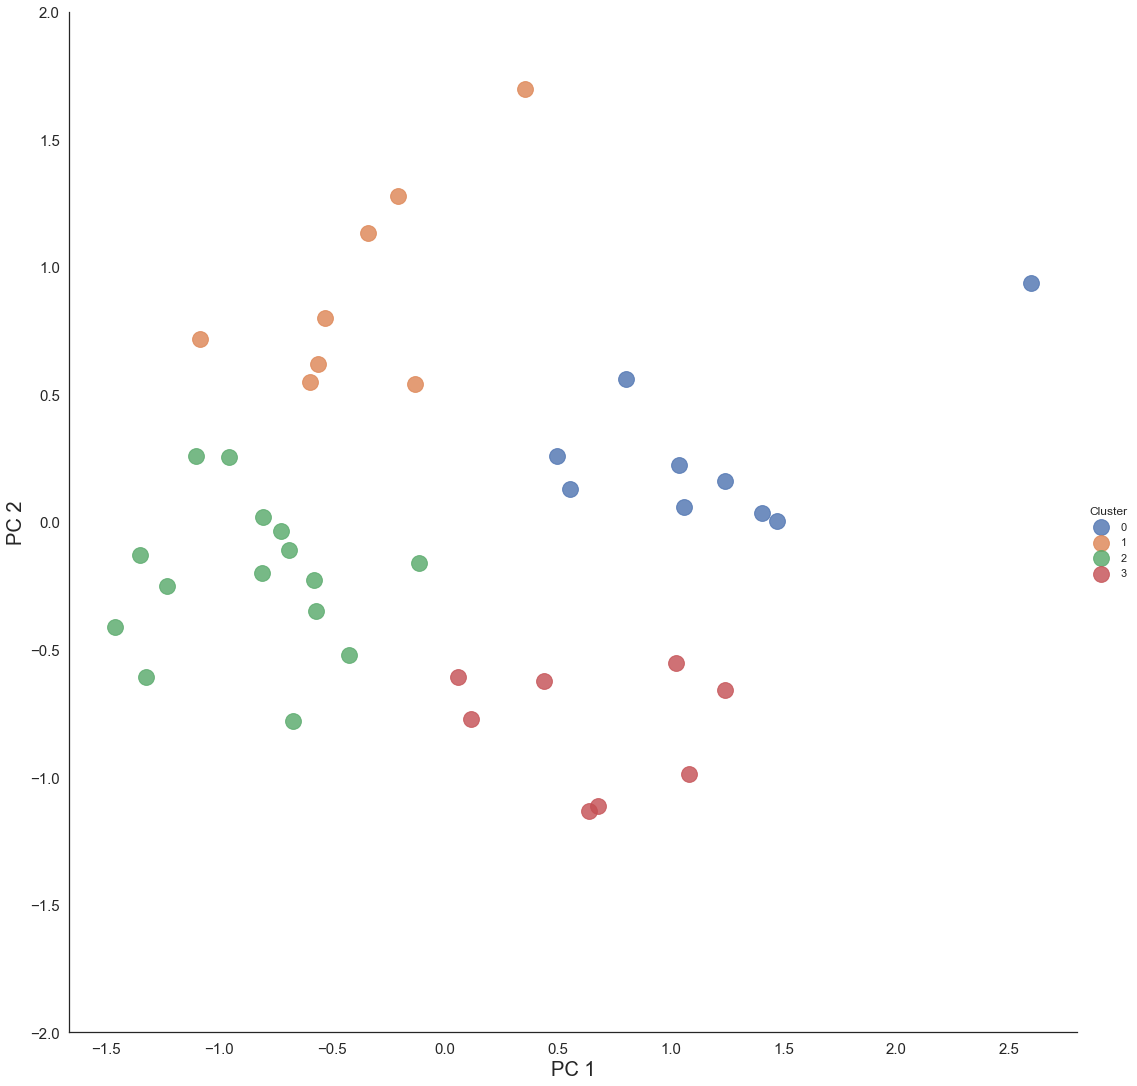

In [96]:
# Visualise the clustering
sns.set(style = 'white')
ax = sns.lmplot(x = "X", y = "Y", hue = 'Cluster', data = result_def, legend = True,
fit_reg = False, size = 15, scatter_kws = {"s": 250})
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize = 15)
plt.xlabel('PC 1', fontsize = 20)
plt.ylabel('PC 2', fontsize = 20)
plt.show()